## Importing libraries

In [48]:
# Data manipulation
import numpy as np
import pandas as pd
import datetime as dt
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# Data Retrieval
from power.ml_ops.data import clean_pv_data, get_pv_data

# System
import os

# Manipulating temporal data and check the types of variables
from typing import Dict, List, Tuple, Sequence

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

## Loading PV dataset

In [49]:
pv_raw_data = get_pv_data()
pv_df = clean_pv_data(pv_raw_data)
pv_df.head(3)

# data loaded
# data cleaned


,utc_time,local_time,electricity
0,1980-01-01 00:00:00+00:00,1980-01-01 01:00:00+01:00,0.0
1,1980-01-01 01:00:00+00:00,1980-01-01 02:00:00+01:00,0.0
2,1980-01-01 02:00:00+00:00,1980-01-01 03:00:00+01:00,0.0


In [52]:
pv_df.rename(columns={'electricity': 'power'}, inplace=True)

In [53]:
pv_df =pv_df[['power']]

In [54]:
pv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376944 entries, 0 to 376943
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   power   376944 non-null  float64
dtypes: float64(1)
memory usage: 2.9 MB


In [55]:
pv_df.shape

(376944, 1)

👆 In the preprocessed dataset, we have :
- 376k rows  (42 years of pv power data)
- 1 feature: <font color=green>**target**</font> (we will use the past values of the pv power as a feature)

This weather dataset is a DataFrame (dimension = 2) which is a single Time Series from the beginning of 1980 to the end 2022 with records every single hour.

* `df.shape = (n_timesteps, n_features) = (376944, 3)`

**Note:** For the rest of this notebook, we will ignore the timestamps columns and work only with pv power values.

In [56]:
TARGET = 'power'
N_TARGETS = 1
N_FEATURES = 1

## Visualizing the time series

In [57]:
plot_cols = [TARGET]                        # a list with one column of the original df
plot_features = pv_df[plot_cols]            # creates new df Plot_features passing the filter [plot_cols]
plot_features.index = pv_df.index           # indices of plot_features will be the same as df


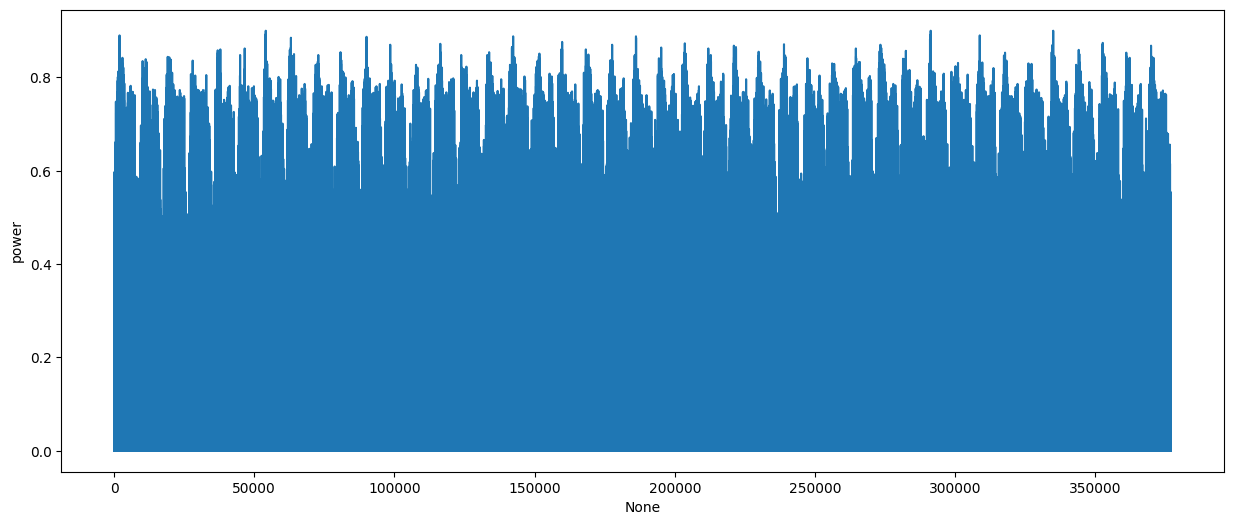

In [58]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=plot_features, x=plot_features.index, y='power');

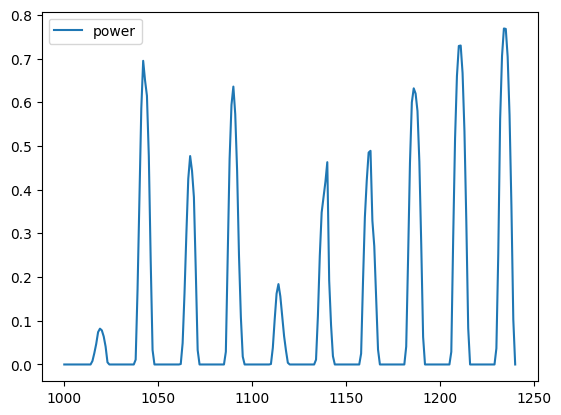

In [59]:
# slice(start, stop, step) returns a slice object that is used to slice any sequence.

zoomed_slice = slice(1000,1240) # 10 days worth of data

plot_features = pv_df.loc[zoomed_slice, plot_cols]
plot_features.plot();

## Preparing the pv dataset

* Step 1: Cross-Validation in Time Series [FOLDS]
* Step 2: Holdout method within each fold [TRAIN-TEST SPLIT]
* Step 3: Sampling SEQUENCES in both the train set and the test set

### Creating FOLDS for cross-validation

In [60]:
# Let's consider FOLDS with a length of 6 years       #
# (5 years will be used for train, 1 for test!)       #

FOLD_LENGTH = 24 * 365 * 6                            # 24 times a day * for 365 days (1 year) * for 6 years

# Let's consider FOLDS starting every year            #

FOLD_STRIDE = 24 * 365 * 6                            # 24 times a day for 365 days (1 year) for 6 years

# Let's consider a train-test-split ratio of 5/6      #

TRAIN_TEST_RATIO = 0.83                               # 5 years train, 1 year test

In [61]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Returns a list of folds, each as a DataFrame
    '''
    folds = []
    for idx in range(0, len(df), fold_stride):
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]  # select from row idx til last row of the fold (6 years), all the columns
        folds.append(fold)                        # append the 6 year fold to folds
    return folds

### Train/Test Split

We want to split this fold **chronologically** into:

- a train dataframe
- a test dataframe

that will contain all the data we need to be able to sample many `(X_i, y_i)` pairs in each dataframe in a next step! 
The `INPUT_LENGTH` of each `X_i` is going to be equal to 2 weeks.

In [62]:
INPUT_LENGTH = 24 * 2       # records every hour (24 hours) x 2 days = 48

Function `train_test_split` below:
- <i>(input)</i> given a `fold` (like above), a `train_test_ratio` (e.g 0.8) and an `input_length` (fixed)
- <i>(output)</i> a tuple of (`fold_train`, `fold_test`) dataframes


**NOTE:** 

This following functions will focus on one fold only. Later, when we are done with the splitting and sequencing of one fold, we will call both of the them inside a function and will loop over all folds.

In [63]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    '''
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))    # 83% of the fold for train
    fold_train = fold.iloc[0:last_train_idx, :]             # 1st until last row of train set, all columns

    # TEST SET
    # ======================
    first_test_idx = last_train_idx - input_length          # last row of train set - 2 weeks --> test set starts 2 weeks
                                                            # before train set ends --> overlap (not a problem with X)
    fold_test = fold.iloc[first_test_idx:, :]               # 1st until last row of test set, all columns

    return (fold_train, fold_test)

### Create (X, y) sequences

Now that we have splitted our fold into a **train** set and a **test** set, it is time to:
- sample lots of sequences $(X_i, y_i)$ on which the model will be **trained**
- sample lots of sequences $(X_i, y_i)$ on which the model will be **evaluated**

We are now dealing with **3D arrays** instead of **2D DataFrames** time-series:
* `X_train.shape = (n_samples_train, input_length, n_features)`
* `y_train.shape = (n_samples_train, output_length, n_targets)`

In [64]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/24)} days = {int(INPUT_LENGTH/24/7)} weeks')

N_FEATURES = 1
INPUT_LENGTH = 48 timesteps = 2 days = 0 weeks


**X** is the **input** of our model. 
- It contains one single feature: the past values of the **target**
- Each sequence has a length equal to $336$ timesteps (=$2$ weeks)

In [65]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

OUTPUT_LENGTH = 24
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 24


**y** is the **target** that we want to predic:
- It is the values at the next 24 timestep (= 24 hours later)

To create these SEQUENCES within the **train** set and the **test** set,

### Option 1:

we can scan a fold chronologically and create all the possible pairs $(X_i, y_i)$.

The following function will scan a fold chronologically based on:
  - an `input_length` (`INPUT_LENGTH = 24 * 2`, i.e. two days) 
  - and a `sequence_stride`

Let's scan the fold with a temporal stride of only 1 hour (the minimum one):

In [33]:
SEQUENCE_STRIDE = 24 * 3                # (three days)

In [30]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
      using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]] # index + length of sequence until index + length of seq. + length of target
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

### Option 2: Generating one random sequence

Function `get_Xi_yi`:
- <i>(input)</i> given a fold, an `input_length` and an `output_length`
- <i>(output)</i> returns a sequence $(X_i,y_i)$

In [66]:
def get_Xi_yi(
    fold:pd.DataFrame,
    input_length:int,       # 48
    output_length:int,      # 24
    gap_hours):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    - TARGET is the variable(s) we want to predict (name of the column(s))
    '''
    TARGET = 'power'
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + gap_hours + output_length) + 1

    random_start = np.random.randint(first_possible_start, last_possible_start)

    input_start = random_start
    input_end = random_start + input_length
    target_start = input_end + gap_hours
    target_end = target_start + output_length

    X_i = fold.iloc[input_start:input_end]
    y_i = fold.iloc[target_start:target_end][[TARGET]]    # creates a pd.DataFrame for the target y

    return (X_i, y_i)

### Generating multiple random sequences

Function `get_X_y`:
- <i>(input)</i> given a fold, a `number_of_sequences` an `input_length` and an `output_length`
- <i>(output)</i> returns $(X,y)$

In [67]:
def get_X_y_seq(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int,
    gap_hours=0):
    '''
    Given a fold, it creates a series of sequences randomly
    as many as being specified
    '''

    X, y = [], []                                                 # lists for the sequences for X and y

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length, gap_hours)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)


## Modeling

The Mean Absolute Error seems to be a reasonable metrics to evaluate a model's capability to predict the temperature because an error of 4 degrees is simply twice as bad as an error of 2 degrees:

$$ MAE = \frac{1}{n_{samples}} \times \sum_{i = 1}^{n_{samples}} |y_{true}^{(i)} - y_{pred}^{(i)}|$$

### RNN: the `LSTM`

- Creating a function `init_model` which builds and compiles a simple RNN with an LSTM layer

In [68]:
from tensorflow.keras import models, layers, optimizers, metrics


def init_model(X_train, y_train):


    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(24,
                          activation='tanh',
                          return_sequences = False,
                          input_shape=(X_train.shape[1],X_train.shape[2])
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

### A Baseline Model to compare our LSTM with!

This baseline model is to predict the **last seen values** for the future value(s) you want to forecast

The following method `init_baseline` that initializes and compiles a baseline model in a similar way to the LSTM.

- The baseline should be as a [Keras Lambda Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda)
- It should not even need a `fit` because it should have 0 trainable params
- Then, we compute the MAE for this FOLD and compare it with the MAE we obtained on the test set after training the LSTM 

In [69]:
from tensorflow.keras.layers import Lambda              # Wraps arbitrary expressions as a Layer object

def init_baseline():

    model = models.Sequential()
    # a layer to take the last value of the sequence and output it
    model.add(layers.Lambda(lambda x: x[:,-25:-1,0,None]))  # all sequences, last day, 1 feature (pv_power)


    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

### Cross-Validation

* We just did (train/test split) and (get_X_y) only **for one single FOLD**. 
* ***If we want to ensure the robustness of a model, we need to cross-validate the model on ALL the folds!***

In [39]:
# Reminders of the global variables in this notebook

print(f'N_FEATURES = {N_FEATURES}')
print(f'N_TARGETS = {N_TARGETS}')
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')
print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_FEATURES = 1
N_TARGETS = 1

FOLD_LENGTH = 52560
FOLD_STRIDE = 52560
TRAIN_TEST_RATIO = 0.83

INPUT_LENGTH = 48
OUTPUT_LENGTH = 24


**Cross validating our baseline and RNN model in a for-loop!**

Re-using our previously defined methods
- `get_folds`
- `train_test_split`
- `get_X_y`
- `init_model`
- `init_baseline`

In [72]:
def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(pv_df, FOLD_LENGTH, FOLD_STRIDE)  # function we coded to get the folds

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH) # function we coded to split train/test

        N_TRAIN = 250   # number_of_sequences_train
        N_TEST =  50    # number_of_sequences_test


        X_train, y_train = get_X_y_seq(fold_train, number_of_sequences=N_TRAIN, input_length=48, output_length=24, gap_hours=12)
        X_test, y_test = get_X_y_seq(fold_test, number_of_sequences=N_TEST, input_length=48, output_length=24, gap_hours=12)

        # X_train = np.delete(X_train, [0, 1], 2)
        # X_test = np.delete(X_test, [0, 1], 2)

        # X_train = X_train.astype('float32')
        # X_test = X_test.astype('float32')

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]   # evaluating baseline model (metric)
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        #### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                          # mode = "min",
                           patience = 5,
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [73]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

--------------------------------------------------
MAE baseline fold n°0 = 0.25


2024-03-12 12:44:22.787939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 12:44:22.791351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 12:44:22.794056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MAE LSTM fold n°0 = 0.08
improvement over baseline: 67.11 % 

--------------------------------------------------
MAE baseline fold n°1 = 0.25


2024-03-12 12:44:30.621865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 12:44:30.625710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 12:44:30.627884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MAE LSTM fold n°1 = 0.07
improvement over baseline: 73.36 % 

--------------------------------------------------
MAE baseline fold n°2 = 0.28


2024-03-12 12:44:37.824951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 12:44:37.827058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 12:44:37.828559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MAE LSTM fold n°2 = 0.07
improvement over baseline: 74.52 % 

--------------------------------------------------
MAE baseline fold n°3 = 0.27


2024-03-12 12:44:47.601165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 12:44:47.603669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 12:44:47.605873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MAE LSTM fold n°3 = 0.06
improvement over baseline: 78.01 % 

--------------------------------------------------
MAE baseline fold n°4 = 0.28


2024-03-12 12:44:57.310701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 12:44:57.314225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 12:44:57.315977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MAE LSTM fold n°4 = 0.06
improvement over baseline: 77.64 % 

--------------------------------------------------
MAE baseline fold n°5 = 0.3


2024-03-12 12:45:07.662079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 12:45:07.663813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 12:45:07.665974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MAE LSTM fold n°5 = 0.08
improvement over baseline: 74.37 % 

--------------------------------------------------
MAE baseline fold n°6 = 0.27


2024-03-12 12:45:14.243932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 12:45:14.246579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 12:45:14.248514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

MAE LSTM fold n°6 = 0.07
improvement over baseline: 75.71 % 



In [74]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = 74.0%
